# Credit Risk Assessment Project - Give Me Some Credit Dataset
## Author: Erdem Tosun

# ======================================
## 1. Installing Required Libraries
# ======================================


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# ======================================
## 2.Data Loading and Review
# ======================================

#### The Give Me Some Credit dataset aims to estimate the risk of future default based on individuals' credit history.


In [9]:
df = pd.read_csv("cs-training.csv", index_col=0)
df.columns = df.columns.str.strip()
df.head()


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [13]:
# fill inside of MonthlyIncome and NumberOfDependents 
df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
df['NumberOfDependents'] = df['NumberOfDependents'].fillna(0)

# ======================================
###  3. Data Preparation
# ======================================


In [14]:
X = df.drop('SeriousDlqin2yrs', axis=1)
y = df['SeriousDlqin2yrs']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ======================================
### 4. Model Training (Logistic + LightGBM)
# ======================================


In [15]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 8070, number of negative: 111930
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 981
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.067250 -> initscore=-2.629720
[LightGBM] [Info] Start training from score -2.629720


LGBMClassifier()

# ======================================
### 5. Model Evaluation
# ======================================


In [20]:
best_model = None
best_score = 0
best_name = ""

models = {'Logistic Regression': logreg, 'LightGBM': lgb_model}

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)

    print(f"\nModel: {name}")
    print("ROC-AUC:", auc)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    if auc > best_score:
        best_score = auc
        best_model = model
        best_name = name
        
print(f"Best Model is {best_name} with score of {best_score}")



Model: Logistic Regression
ROC-AUC: 0.6928167072543613
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     28044
           1       0.52      0.04      0.07      1956

    accuracy                           0.94     30000
   macro avg       0.73      0.52      0.52     30000
weighted avg       0.91      0.94      0.91     30000


Model: LightGBM
ROC-AUC: 0.8628175753760013
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     28044
           1       0.58      0.20      0.29      1956

    accuracy                           0.94     30000
   macro avg       0.76      0.59      0.63     30000
weighted avg       0.92      0.94      0.92     30000

Best Model is LightGBM with score of 0.8628175753760013


# ======================================
### 7. Visualizing Best Model
# ======================================

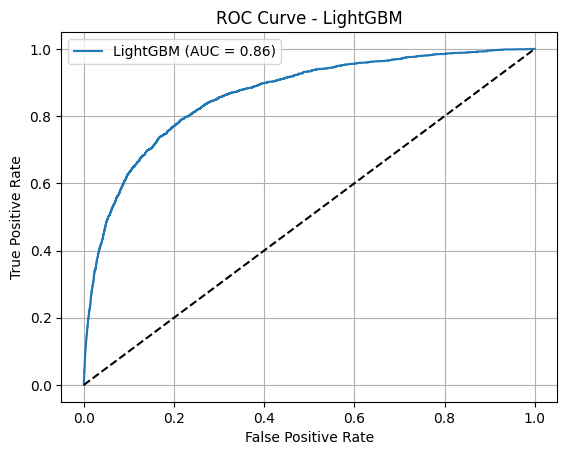

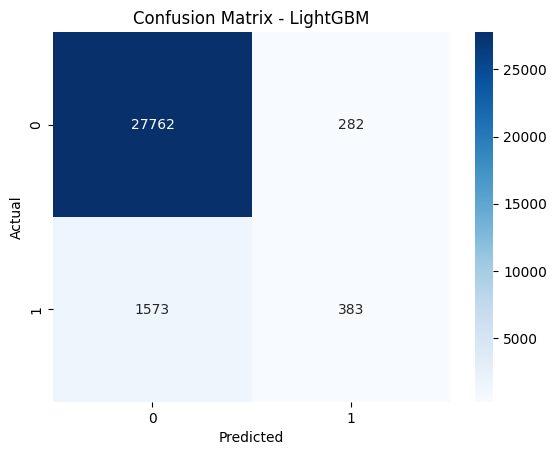

In [21]:
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_best)
plt.plot(fpr, tpr, label=f"{best_name} (AUC = {best_score:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_name}')
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ======================================
### 7. Saving Model
# ======================================

In [22]:
joblib.dump(lgb_model, "models/credit_lgbm_model.pkl")
joblib.dump(scaler, "models/credit_scaler.pkl")


['models/credit_scaler.pkl']